![](../images/rivacon_frontmark_combined_header.png)

# Interest Rate Swap 

In [1]:
import pyvacon
import pyvacon.analytics as analytics
import datetime
import pyvacon.tools.converter as converter
import pyvacon.marketdata.testdata as mkt_testdata
import pyvacon.marketdata.plot as mkt_plot
import pyvacon.tools.enums as enums
import math
%matplotlib inline

C:\Users\Anwender\Anaconda3\lib\site-packages\pyvacon\__init__.py:10: UserWarning: Imported pyvacon is just beta version.
  warnings.warn('Imported pyvacon is just beta version.')


## Definition of an Interest Rate Swap

The most common type of an interest rate swap is the so called "plain vanilla" interest rate swap. Here, a company agrees to pay cashflows equal to a predetermined fixed interest rate on a notional principal during a predetermined number of years; in return, it receives interest payments on the same notional principal at a floating rate during the same number of years.


## Valuation of Interest Rate Swaps

The value of a swap can, for example, be regarded as the difference between two bonds. From the point of view of a fixed-rate payer, the value of the swap can be regarded as a long position in a floating-rate bond and a short position in a fixed-rate bond.

$$V_{swap} = B_{float} - B_{fix}$$

Alternatively, a plain vanilla interest rate swap can also be valued making the assumption that forward interest rates are realized. Here, cashflows of the floating leg are calculated assuming that the floating interest rate equals the forward interest rates. The value of the interest rate swap is then the sum of the present value of the net cashflows. This method will be applied in the following.

For a detailed discussion please refer to Hull, *Options, futures, and other derivatives, 8th Edition,* 2012, p. 148 ff.

In the following, we will use a slighly modified example taken from Hull, p. 161 to illustrate how a interest rate swap can be valued.

**Example:**

*Suppose that a financial institution has agreed to pay 6-month LIBOR and receive 8% per annum (with semiannual compounding) on a notional principal of \$100 million. The swap has a remaining life of 1.5 years. The LIBOR rates with continuous compunding for 6-month, 12-month, and 18-month maturities are 10%, 10.5%, and 11%, respectively.*

### Valuation in terms of bond prices

**Fixed Leg**

The fixed-rate bond has three payment dates in 6 months, 12 months, and 18 months with a cashflow of \$4 million at the first two payment dates and a cashflow of \$4 million plus the notional of $100 million at the last payment date. These cashflows have to be discounted using the given LIBOR rates and subsequently summed up to receive the present value of the fixed leg.

**Floating Leg**

The floating leg bond is worth the notional immediately after an interest payment because at this time, the bond is a "fair deal" where the borower pays LIBOR for earch subsequent accrual period. Consequently, immediately before a payment, the bond is worth the notional plus the accrued interest. Also, this cashflow has to be discounted using the given LIBOR rate.

In [2]:
#Fixed Leg
time_to_maturity = [0.5, 1.0, 1.5]
cf_fix = [4, 4, 104]
libor_rates = [0.1, 0.105, 0.11]

df = analytics.vectorDouble()
for i in range(len(time_to_maturity)):
    df.append(math.exp(-libor_rates[i]*time_to_maturity[i]))

pv_cf_fix = analytics.vectorDouble()
for i in range(len(df)):
    pv_cf_fix.append(cf_fix[i]*df[i])
    print('pv_cf:fix.append: ', pv_cf_fix[i])
    
B_fix = sum(pv_cf_fix)
print('Fixed Leg Value = ', B_fix)


# Floating Leg
floating_rate = 2*(math.exp(libor_rates[0]/2)-1) # libor rate has to be converted from contiuous compounding to semiannual comp.
cf_float = 100+(100*floating_rate*0.5) # 1/2 of converted libor_rate as semiannual payment
pv_cf_float = cf_float*df[0] # discounted with 3-month libor rate
print('Floating Leg Value = ',pv_cf_float)


# Interest Rate Swap Valuation (from a fixed-rate payer's perspective)
value = (pv_cf_float-B_fix)
print('Interest Rate Swap Value = ',value)

pv_cf:fix.append:  3.804917698002856
pv_cf:fix.append:  3.6012980903450624
pv_cf:fix.append:  88.18094522514325
Fixed Leg Value =  95.58716101349117
Floating Leg Value =  100.00000000000001
Interest Rate Swap Value =  4.412838986508845



### Valuation in terms of forward rate agreements

As before, the value of the interest rate swap is given as the difference between the present value of the fixed and the floating leg.

**Fixed Leg**

The present value of the fixed leg is given by:

$$PV_{fixed}(t) = rN\sum_{i=1}^n\tau_iD_i$$

with $t$ as the valuation date, $r$ as the interest rate of the fixed leg, $N$ as the notional principal, $i$ as the $i^{th}$ cashflow, $\tau_i$ as the accrual period for the $i^{th}$ cashflow and $D_i$ as the discount factor of the $i^{th}$ period.




**Floating Leg**

The present value of the float leg is given by:

$$PV_{floating}(t)=N\sum_{i=1}^n(F_i+s)\tau_iD_i$$

with $F_i$ as the simply compounded forward rate defined as $\frac{1}{\tau_i}(\frac{D_{i-1}}{D_i}-1)$, $s$ as the floating spread and the rest defined as before.

Note that the discount factors used for the forward rate can be different from the discount factor used to discount the cashflows. Also, a different discount factors from the fixed leg are theoretically possible.

The following code manually calculates the value of the interest-rate swap. Thereby, the formula for the floating leg assuming that there is no spread $s$ is simplified as follows:

\begin{align}
PV_{floating}(t) & =N\sum_{i=1}^n\frac{1}{\tau_i}(\frac{D_{i-1}}{D_i}-1)\tau_iD_i \\
& =N\sum_{i=1}^n(\frac{D_{i-1}}{D_i}-1)D_i \\
& =N\sum_{i=1}^n(D_{i-1}-{D_i}) \\
& =N\cdot[(D_0-D_1)+(D_1-D_2)+ ... +(D_{n-2}-D_{n-1})+(D_{n-1}-D_n)] \\
& =N\cdot(D_0-D_n)
\end{align}

In [3]:
ttm = [0.5, 1, 1.5]
rates = [0.1, 0.105, 0.11]
yf = [0.25, 0.75, 1.25]
r = 0.08
N=100

df = analytics.vectorDouble()
for i in range(len(ttm)):
    df.append(math.exp(-rates[i]*ttm[i]))
    
PV_fix = r*N*((ttm[0]-0)*df[0]+(ttm[1]-ttm[0])*df[1]+(ttm[2]-ttm[1])*df[2])
print('PV fixed leg =',PV_fix)

PV_fl = N*(1-df[2])
print('PV floating leg =',PV_fl)

print('Interest rate swap value =',PV_fl-PV_fix)

PV fixed leg = 10.797790604699582
PV floating leg = 15.210629591208413
Interest rate swap value = 4.412838986508831


The following code shows the manual calculation of the example as it is done by Hull:

In [4]:
ttm = [0.5, 1.0, 1.5]
rates = [0.1, 0.105, 0.11]
N = 100 # Notional
m = 2 # compounding frequency

refdate = analytics.ptime(2017,1,1,0,0,0)
days_to_maturity = [180, 360, 540]
dates = converter.createPTimeList(refdate, days_to_maturity)
# discount factors from constant rate
df = analytics.vectorDouble()
for i in range(len(rates)):
    df.append(math.exp(-rates[i]*ttm[i]))

# Fixed leg
fix_cf = [4,4,4]

pv_fix=analytics.vectorDouble()
for i in range(len(fix_cf)):
    pv_fix.append(fix_cf[i]*df[i])
print('Present value fixed leg =', sum(pv_fix))


# Floating leg
floatrates = analytics.vectorDouble()
floatrates.append(m*(math.exp(rates[0]/m)-1)) # first libor rate converted to semiannual compounding

for i in range(len(rates)):
    if i > 0:
        contrate = ((rates[i]*ttm[i]-rates[i-1]*ttm[i-1])/(ttm[i]-ttm[i-1])) 
        floatrates.append(m*(math.exp(contrate/m)-1)) # second and third floating rate conv. to semi-annual comp.

float_cf = analytics.vectorDouble()
for i in range(len(floatrates)):
    float_cf.append(floatrates[i]*N/m)

float_pv = analytics.vectorDouble()
for i in range(len(float_cf)):
    float_pv.append(float_cf[i]*df[i])
print('Present value floating leg =', sum(float_pv))


# Net Cash-Flow
net_CF = analytics.vectorDouble()
for i in range(len(fix_cf)):
    net_CF.append(float_cf[i]-fix_cf[i])
    
pv_net_cf = analytics.vectorDouble()
for i in range(len(df)):
    pv_net_cf.append(net_CF[i]*df[i])
    
value = sum(pv_net_cf)
print('Interest rate swap value = ',value)

Present value fixed leg = 10.797790604699582
Present value floating leg = 15.210629591208427
Interest rate swap value =  4.412838986508847


### Valuation using the pyvacon interest rate swap specification

The pyvacon interest rate swap specification uses the valuation in terms of forward rate agreements. In order to price an interest rate swap, we need to create the necessary market data and setup the specification and pricing data.

#### Create the necessary market data

As a first step, we need to create a discount curve containing the discount factors to derive the present values of both, the fixed and the floating leg. Here, we use this discount curve to derive the forward rate discount factors as well. Theoretically, we could also use different discount curves for the fixed and floating legs as well as for the forward rates.

In [5]:
# Discount curve - we use these discount factors to get the present values of both the fixed and floating leg as well as 

object_id = "TEST_DC" 
refdatedc = analytics.ptime(2017,1,1,0,0,0)
days_to_maturity = [180, 360, 540]
dates = converter.createPTimeList(refdatedc, days_to_maturity)
# discount factors from constant rate
rates = [0.10, 0.105, 0.11]
df = analytics.vectorDouble()
for i in range(len(rates)):
    df.append(math.exp(-rates[i]*days_to_maturity[i]/360))
dc = analytics.DiscountCurve(object_id, refdatedc,dates, df, enums.DayCounter.ACT365_FIXED, enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE)

#### Setup the specification

Here, we need to provide the start-, end-, and pay-dates for the different accrual periods. The floating leg additionally needs a reset date vector. Moreover, we need to define a vector of notionals since if needed, each accrual period may have a different notional. However, if the vector if of length 1, the same notional is applied to all periods.

Having defined the relevant information, we are able to  create the fixed- and floating leg. The fixed leg needs to be provided with the fixed rate; the float leg requires information about an eventual spread. Afterwards, the interest rate swap specification can be set.

In [6]:
# Create the vectors defining the statdates, enddates, paydates and reset dates
days_to_maturity = [0, 180, 360, 540]
dates = converter.createPTimeList(datetime.datetime(2017,1,1), days_to_maturity)

startdates = [dates[0], dates[1], dates[2]]
enddates = [dates[1], dates[2], dates[3]]
paydates = enddates
resetdates = startdates
refdate = dates[0]

notionals = analytics.vectorDouble()
notionals.append(100.0)

fixedleg = analytics.IrFixedLegSpecification(0.08, notionals, startdates, enddates, 
                                       paydates,'EUR', enums.DayCounter.ACT365_FIXED)
spread = 0.00
floatleg = analytics.IrFloatLegSpecification(notionals, resetdates, startdates, enddates,
                                       paydates,'EUR', 'test_udl', enums.DayCounter.ACT365_FIXED, 
                                       spread)

ir_swap = analytics.InterestRateSwapSpecification('TEST_SWAP', 'DBK', enums.SecuritizationLevel.COLLATERALIZED, 'EUR',
                                           converter.getLTime(paydates[-1]), fixedleg, floatleg)


#### Setup the pricing data

A product may be priced in two different ways: One may either fill the respective pricing data needed for a special pricer (which inherits from th BasePricingData) and use the respective price method where just the pricing data is given. Another possibility is to use the price-method where the storages are given. In this case, the pricer will fill the needed pricing data according to the underlying and other data as specified in the product specification.

**Here we show the approach explicitely setting the pricing data.**  

The pricing data needs the following information:
- A discount curve for the pay- and receive leg
- A discount curve for the floating leg (here the receiving leg)
- A pricer
- A pricing request
- A valuation date
- The created interest rate swap specification
- An eventual FX-rate for the pay- and receive leg

In [7]:
ir_swap_pricing_data = analytics.InterestRateSwapPricingData()
pay_leg_pricing_data = analytics.InterestRateSwapLegPricingData()
pay_leg_pricing_data.discountCurve = dc
pay_leg_pricing_data.spec = ir_swap.getPayLeg()
pay_leg_pricing_data.fxRate = 1.0
pay_leg_pricing_data.weight = -1.0
rec_leg_pricing_data = analytics.InterestRateSwapFloatLegPricingData()
rec_leg_pricing_data.discountCurve = dc
rec_leg_pricing_data.fixingCurve = dc
rec_leg_pricing_data.spec = ir_swap.getReceiveLeg()
rec_leg_pricing_data.fxRate = 1.0
rec_leg_pricing_data.weight = 1.0
ir_swap_pricing_data.pricer = 'InterestRateSwapPricer'
ir_swap_pricing_data.pricingRequest = analytics.PricingRequest()
ir_swap_pricing_data.valDate = converter.getLTime(refdate)
ir_swap_pricing_data.setCurr('EUR')
ir_swap_pricing_data.addLegData(pay_leg_pricing_data)
ir_swap_pricing_data.addLegData(rec_leg_pricing_data)

#### Pricing

In [8]:
analytics.setLogLevel('DEBUG')
tic = datetime.datetime.now()
pr = analytics.price(ir_swap_pricing_data)
print('runtime: {}'.format(datetime.datetime.now() - tic))
pr.getPrice()

runtime: 0:00:00.147603


4.560753924262983

### Further Example
#### Create the necessary market data

This time, we distinguish between the discount curve used to discount the cashflows to present values and a discount curve for the calculation of the forward interest rates which we use as fixing curve.

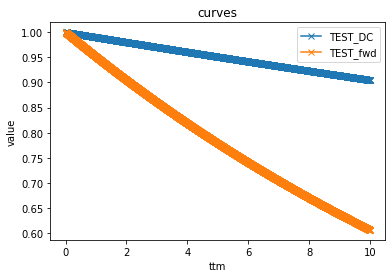

In [9]:
refdatedc = analytics.ptime(2017,1,1,0,0,0)
days_to_maturity = [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = converter.createPTimeList(refdatedc, days_to_maturity)

# Discount curve
object_id = "TEST_DC" 
dsc_rate = 0.01
df = analytics.vectorDouble()
for d in days_to_maturity:
    df.append(math.exp(-d/365.0*dsc_rate))
dc = analytics.DiscountCurve(object_id, refdatedc,dates, df, enums.DayCounter.ACT365_FIXED, enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE)

# Fixing curve
object_id = "TEST_fwd"
fwd_rate = 0.05
fwd_df = analytics.vectorDouble()
for d in days_to_maturity:
    fwd_df.append(math.exp(-d/365.0*fwd_rate))
fwd_dc = analytics.DiscountCurve(object_id, refdatedc,dates, fwd_df, enums.DayCounter.ACT365_FIXED, enums.InterpolationType.HAGAN_DF, enums.ExtrapolationType.NONE)

mkt_plot.curve(dc,range(1,10*365), refdatedc)
mkt_plot.curve(fwd_dc,range(1,10*365), refdatedc)

#### Setup the specification
In our example we are using one fixed leg and one floating leg (with just two payment and fixing dates)
The swap needs to get vectors with start, end, and payment dates (floater additionally need a rest date vector). The i-th accrual period is defined by the i-th entry of start and end vectors.
Note that this kind of swap has only floating legs with floating rate period equal to accrual period.

In [10]:
# Create the vectors defining the statdates, enddates, paydates and reset dates
days_to_maturity = [0, 180, 360, 540]
dates = converter.createPTimeList(datetime.datetime(2017,1,1), days_to_maturity)

startdates = [dates[0], dates[1], dates[2]]
enddates = [dates[1], dates[2], dates[3]]
paydates = enddates
resetdates = startdates
refdate = dates[0]

# We need a vector of notionals since if needed, each accrual period may have a different notional
# However, if the vector is of length 1 the same notional is applied to all periods
notionals = analytics.vectorDouble()
notionals.append(100.0)

fixedleg = analytics.IrFixedLegSpecification(0.03, notionals, startdates, enddates, 
                                       paydates,'EUR', enums.DayCounter.ACT365_FIXED)
spread = 0.00
floatleg = analytics.IrFloatLegSpecification(notionals, resetdates, startdates, enddates,
                                       paydates,'EUR', 'test_udl', enums.DayCounter.ACT365_FIXED, 
                                       spread)

ir_swap = analytics.InterestRateSwapSpecification('TEST_SWAP', 'DBK', enums.SecuritizationLevel.COLLATERALIZED, 'EUR',
                                           converter.getLTime(paydates[-1]), fixedleg, floatleg)

#### Setup the pricing data

In [11]:
ir_swap_pricing_data = analytics.InterestRateSwapPricingData()
pay_leg_pricing_data = analytics.InterestRateSwapLegPricingData()
pay_leg_pricing_data.discountCurve = dc
pay_leg_pricing_data.spec = ir_swap.getPayLeg()
pay_leg_pricing_data.fxRate = 1.0
pay_leg_pricing_data.weight = -1.0
rec_leg_pricing_data = analytics.InterestRateSwapFloatLegPricingData()
rec_leg_pricing_data.discountCurve = dc
rec_leg_pricing_data.fixingCurve = fwd_dc
rec_leg_pricing_data.spec = ir_swap.getReceiveLeg()
rec_leg_pricing_data.fxRate = 1.0
rec_leg_pricing_data.weight = 1.0
ir_swap_pricing_data.pricer = 'InterestRateSwapPricer'
ir_swap_pricing_data.pricingRequest = analytics.PricingRequest()
ir_swap_pricing_data.valDate = converter.getLTime(refdate)
ir_swap_pricing_data.setCurr('EUR')
ir_swap_pricing_data.addLegData(pay_leg_pricing_data)
ir_swap_pricing_data.addLegData(rec_leg_pricing_data)

#### Pricing

In [12]:
tic = datetime.datetime.now()
pr = analytics.price(ir_swap_pricing_data)
print('runtime: {}'.format(datetime.datetime.now() - tic))
pr.getPrice()

runtime: 0:00:00.052860


3.0209391798447705

---